The following code helps you visualize the submarine data and contains the crucial information about the data such as size of measurement domain, number of grid points and frequency modes etc. 

Our first task is to import the data into python (similarly MATLAB). Three files are available, "subdata.npy" is a numpy binary file most convenient for Python users and "subdata.csv" is the same data in text format if you are having trouble with the .npy format. In Python, and in particular if you are using something like Colab you need some utilities to load the data. Here's a small snippet for loading data from your Google drive.   

In [ ]:
%pip install numpy
# import numpy as np
# print(np.__version__)



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
2.0.2


In [4]:

import numpy as np

# data_path = '/Users/you/Downloads/subdata.npy'

# d = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)
d = np.load('subdata.npy')
print(d.shape)


(262144, 49)


The variable d is a 262144 x 49 matrix. Each column contains a flattened 3D matrix of size 64x64x64

In [4]:
%pip install plotly
%pip install nbformat ipython



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 78 kB 9.4 MB/s  eta 0:00:01
     |████████████████████████████████| 90 kB 23.1 MB/s eta 0:00:01
     |████████████████████████████████| 354 kB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 29.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:

# import libraries for plotting isosurfaces
import plotly
import plotly.graph_objs as go
# utility for clearing output of cell as loop runs in notebook
from IPython.display import clear_output

# plot the data in time 

# NOTE: L we defined in class is 2Lh here, i.e. the domain here is [-Lh,Lh].
Lh = 10; # length of spatial domain (cube of side L = 2*10). 
N_grid = 64; # number of grid points/Fourier modes in each direction
xx = np.linspace(-Lh, Lh, N_grid+1) #spatial grid in x dir
x = xx[0:N_grid]
y = x # same grid in y,z direction
z = x

K_grid = (2*np.pi/(2*Lh))*np.linspace(-N_grid/2, N_grid/2 -1, N_grid) # frequency grid for one coordinate

xv, yv, zv = np.meshgrid( x, y, z) # generate 3D meshgrid for plotting

# plot iso surfaces for every third measurement

for j in range(0,49,3):

  signal = np.reshape(d[:, j], (N_grid, N_grid, N_grid))
  normal_sig_abs = np.abs(signal)/np.abs(signal).max()

  # generate data for isosurface of the 3D data 
  fig_data = go.Isosurface( x = xv.flatten(), y = yv.flatten(), z = zv.flatten(),
                           value = normal_sig_abs.flatten(), isomin=0.6, isomax=1)

  # generate plots
  clear_output(wait=True) # need this to discard previous figs
  fig = go.Figure( data = fig_data )
  fig.show()


In [7]:
import numpy as np

# d is (262144, 49). Each column is a flattened 64x64x64 snapshot.
N = 64
T = d.shape[1]
Lh = 10  # from helper: domain is [-Lh, Lh]

# Build frequency grid (consistent with FFT indexing)
k = (2*np.pi/(2*Lh)) * np.concatenate((np.arange(0, N//2), np.arange(-N//2, 0)))
ks = np.fft.fftshift(k)

# 1) average spectrum
avg_spec = np.zeros((N, N, N), dtype=float)

for j in range(T):
    u = d[:, j].reshape(N, N, N)
    F = np.fft.fftn(u)
    Fsh = np.fft.fftshift(F)
    avg_spec += np.abs(Fsh)

avg_spec /= T

# 2) avoid picking DC (optional but usually helps)
c = N//2
avg_spec[c-2:c+3, c-2:c+3, c-2:c+3] = 0

# 3) locate dominant frequency
idx = np.unravel_index(np.argmax(avg_spec), avg_spec.shape)
kx0, ky0, kz0 = ks[idx[0]], ks[idx[1]], ks[idx[2]]
print("peak index:", idx)
print("center frequency (kx0, ky0, kz0):", (kx0, ky0, kz0))


peak index: (np.int64(38), np.int64(49), np.int64(10))
center frequency (kx0, ky0, kz0): (np.float64(1.8849555921538759), np.float64(5.340707511102648), np.float64(-6.911503837897545))


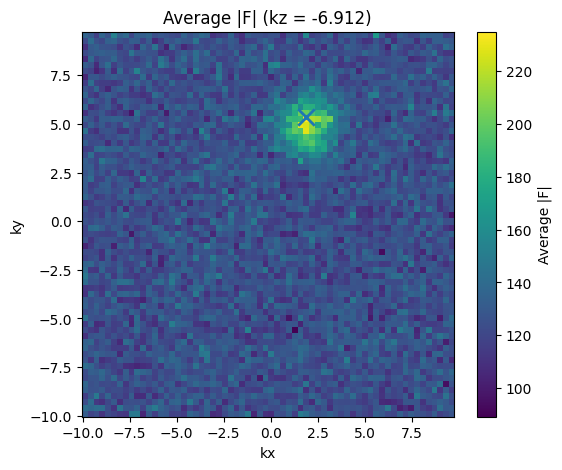

In [ ]:
# # this part is for visualization


import matplotlib.pyplot as plt

iz = idx[2]                    # use the kz index where the global peak occurs
kz_val = ks[iz]

z_slice = avg_spec[:, :, iz]   # take kz = kz0 slice

plt.figure(figsize=(6,5))
plt.imshow(
    z_slice.T,
    origin="lower",
    extent=[ks[0], ks[-1], ks[0], ks[-1]],
    aspect="auto"
)
plt.colorbar(label="Average |F|")
plt.xlabel("kx")
plt.ylabel("ky")
plt.title(f"Average |F| (kz = {kz_val:.3f})")

# mark the dominant frequency peak
plt.scatter(kx0, ky0, marker="x", s=140, linewidths=2)

plt.show()




Task 2
Step A - 3D Gaussian band-pass filter

In [ ]:
# import numpy as np

# Kx, Ky, Kz = np.meshgrid(ks, ks, ks, indexing="ij")

# sigma = 2.0   
# G = np.exp(-sigma * ((Kx-kx0)**2 + (Ky-ky0)**2 + (Kz-kz0)**2))

import numpy as np

# k-space grid
Kx, Ky, Kz = np.meshgrid(ks, ks, ks, indexing="ij")

# ---- bandwidth parameter (in k-units) ----
sigma_k = 1.0   

# distance^2 to +k0 peak
dist2_pos = (Kx - kx0)**2 + (Ky - ky0)**2 + (Kz - kz0)**2
# distance^2 to -k0 peak (real signal usually has conjugate-symmetric peaks)
dist2_neg = (Kx + kx0)**2 + (Ky + ky0)**2 + (Kz + kz0)**2

# Gaussian band-pass filter around both peaks
G = np.exp(-dist2_pos / (2*sigma_k**2)) + np.exp(-dist2_neg / (2*sigma_k**2))

# (optional) remove DC explicitly (usually not needed here, but safe)
G[N//2, N//2, N//2] = 0.0

# normalize so max = 1 (nice for debugging)
G = G / np.max(G)



Step B 

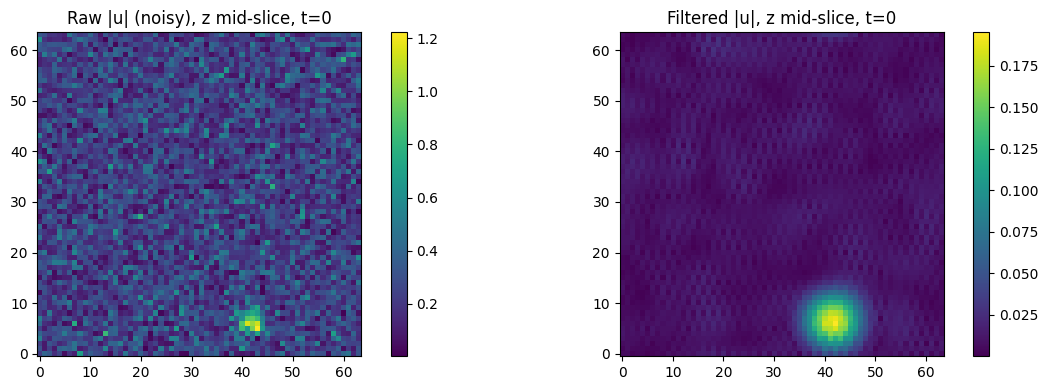

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

j = 0  # pick a time snapshot
u = d[:, j].reshape(N, N, N)

# raw amplitude
u_abs = np.abs(u)

# FFT -> filter -> IFFT
Fsh = np.fft.fftshift(np.fft.fftn(u))
uf = np.fft.ifftn(np.fft.ifftshift(G * Fsh))
uf_abs = np.abs(uf)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(u_abs[:, :, N//2], origin="lower")
plt.colorbar()
plt.title(f"Raw |u| (noisy), z mid-slice, t={j}")

plt.subplot(1,2,2)
plt.imshow(uf_abs[:, :, N//2], origin="lower")
plt.colorbar()
plt.title(f"Filtered |u|, z mid-slice, t={j}")

plt.tight_layout()
plt.show()


Step C 

In [52]:
# xx = np.linspace(-Lh, Lh, N+1)
# x = xx[:N]

# T = d.shape[1]
# traj = np.zeros((T, 3))

# for j in range(T):
#     u = d[:, j].reshape(N, N, N)
#     Fsh = np.fft.fftshift(np.fft.fftn(u))
#     uf = np.fft.ifftn(np.fft.ifftshift(G * Fsh))
#     uf_abs = np.abs(uf)

#     loc = np.unravel_index(np.argmax(uf_abs), uf_abs.shape)
#     traj[j] = [x[loc[0]], x[loc[1]], x[loc[2]]]

# traj[:5]

import numpy as np

xx = np.linspace(-Lh, Lh, N+1)
x = xx[:N]

T = d.shape[1]
traj = np.zeros((T, 3))

for j in range(T):
    u = d[:, j].reshape(N, N, N)

    Fsh = np.fft.fftshift(np.fft.fftn(u))
    uf = np.fft.ifftn(np.fft.ifftshift(G * Fsh))
    uf_abs = np.abs(uf)

    loc = np.unravel_index(np.argmax(uf_abs), uf_abs.shape)
    traj[j] = [x[loc[0]], x[loc[1]], x[loc[2]]]

traj[:5]


array([[-8.125 ,  3.125 ,  0.    ],
       [-7.8125,  2.8125,  0.3125],
       [-7.5   ,  3.125 ,  0.9375],
       [-6.875 ,  3.125 ,  1.25  ],
       [-6.875 ,  3.125 ,  1.5625]])

isosurface

In [ ]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"  


times_to_show = [0, 12, 24, 36, 48]


X, Y, Z = np.meshgrid(x, x, x, indexing="ij")

for j in times_to_show:
    u = d[:, j].reshape(N, N, N)

    # FFT -> filter -> IFFT
    Fsh = np.fft.fftshift(np.fft.fftn(u))
    uf = np.fft.ifftn(np.fft.ifftshift(G * Fsh))
    uf_abs = np.abs(uf)

    
    th = np.quantile(uf_abs, 0.995)

    fig = go.Figure(data=go.Isosurface(
        x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
        value=uf_abs.flatten(),
        isomin=th,
        isomax=uf_abs.max(),
        surface_count=2,     
        caps=dict(x_show=False, y_show=False, z_show=False)
    ))

    fig.update_layout(
        title=f"Filtered |u| Isosurface (t={j})",
        scene=dict(xaxis_title="x", yaxis_title="y", zaxis_title="z")
    )

    fig.show()


Step D - 3D & xy path

In [54]:
# from mpl_toolkits.mplot3d import Axes3D
# # import matplotlib.pyplot as plt
# import plotly.graph_objects as go

# fig = plt.figure(figsize=(6,5))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(traj[:,0], traj[:,1], traj[:,2], marker='o')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")
# ax.set_title("Denoised submarine 3D path")
# plt.show()

import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter3d(
    x=traj[:,0], y=traj[:,1], z=traj[:,2],
    mode='lines+markers'
))
fig.update_layout(
    title="3D submarine trajectory (interactive)",
    scene=dict(xaxis_title="x", yaxis_title="y", zaxis_title="z")
)
fig.show()


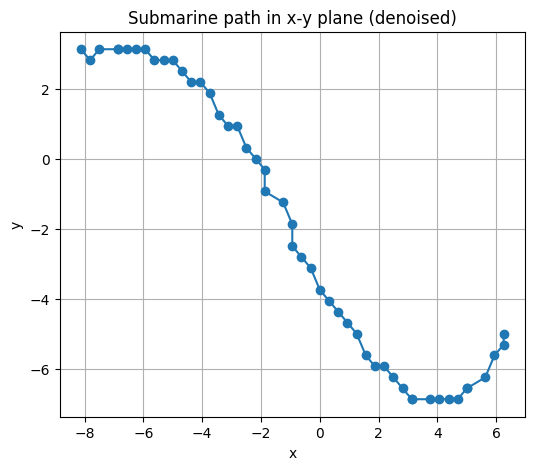

In [29]:
plt.figure(figsize=(6,5))
plt.plot(traj[:,0], traj[:,1], marker='o')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Submarine path in x-y plane (denoised)")
plt.grid(True)
plt.show()


Task 3 

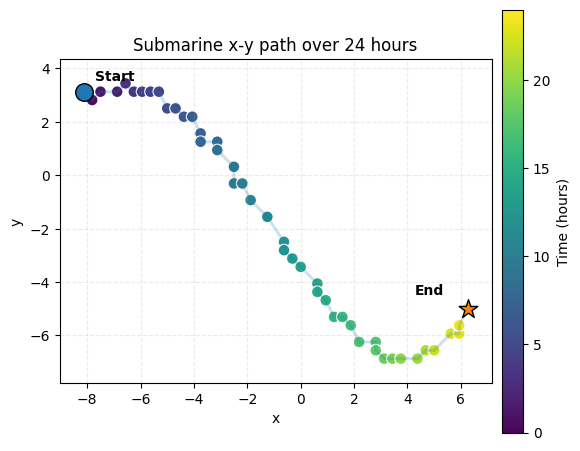

In [60]:
import numpy as np
import matplotlib.pyplot as plt

T = traj.shape[0]                  # 49
t = np.linspace(0, 24, T)          # hours

x = traj[:, 0]
y = traj[:, 1]

plt.figure(figsize=(6,5))

# faint path line
plt.plot(x, y, linewidth=2.2, alpha=0.22)

# time-colored scatter
sc = plt.scatter(
    x, y,
    c=t,
    s=72,
    cmap="viridis",
    edgecolors="white",
    linewidths=0.9,
    alpha=0.98
)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Submarine x-y path over 24 hours")
plt.grid(True, linestyle="--", alpha=0.25)
plt.gca().set_aspect("equal", adjustable="box")

# add padding so labels don't get cut off
pad = 0.9
plt.xlim(x.min()-pad, x.max()+pad)
plt.ylim(y.min()-pad, y.max()+pad)

# colorbar
cbar = plt.colorbar(sc, pad=0.02, shrink=0.9)
cbar.set_label("Time (hours)")

# start/end markers + labels
plt.scatter(x[0],  y[0],  s=160, marker="o", edgecolors="black", linewidths=1.0, zorder=5)
plt.scatter(x[-1], y[-1], s=200, marker="*", edgecolors="black", linewidths=1.0, zorder=6)

plt.annotate("Start", (x[0], y[0]), xytext=(8, 8), textcoords="offset points", weight="bold")
plt.annotate("End",   (x[-1], y[-1]), xytext=(-38, 10), textcoords="offset points", weight="bold")

plt.tight_layout()
plt.show()
